# Monthly Sales Forecasting for DMart

Import Libraries

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb

Import Dataset

In [40]:
sales_data = pd.read_csv("Product_sales_dataset.csv")
sales_data

,Date,Category,SaleID,ProductName,ProductID,Price,Quantity,TotalPrice
0,4/1/2022,Appliances,8e8205ee-e7f5-11ed-b086-f48c5055e0eb,Duracell Chhota Power AA?Batteries,133,95,4,380
1,4/1/2022,Appliances,8e8205ef-e7f5-11ed-bc85-f48c5055e0eb,Kajafa Multifunctional Juicer - 400 W,265,1550,8,12400
2,4/1/2022,Appliances,8e8205f0-e7f5-11ed-acb3-f48c5055e0eb,Usha IH2410 Immersion Heater,563,650,5,3250
3,4/1/2022,Appliances,8e8205f1-e7f5-11ed-84e4-f48c5055e0eb,Eureka Super Clean Vacuum Cleaner,158,3599,4,14396
4,4/1/2022,Appliances,8e8205f2-e7f5-11ed-aa61-f48c5055e0eb,GM Air MT Electric Ceiling Fan - 1200 mm,208,1799,5,8995
...,...,...,...,...,...,...,...,...
219398,3/31/2023,Mobile_stand,92869de4-e7f5-11ed-942b-f48c5055e0eb,ELV Aluminum Adjustable Foldable Stand for All...,151,289,1,289
219399,3/31/2023,Mobile_stand,92869de5-e7f5-11ed-b091-f48c5055e0eb,MADPAIR Invisible Mobile Kickstand Mobile Holder,325,199,5,995
219400,3/31/2023,Mobile_stand,92869de6-e7f5-11ed-9c61-f48c5055e0eb,Flipkart SmartBuy NextGen Multi Angle Mobile S...,185,170,1,170
219401,3/31/2023,Mobile_stand,92869de7-e7f5-11ed-bd38-f48c5055e0eb,Techvor Universal Mobile Holder Metal Mobile s...,508,159,1,159


In [41]:
# # If you want to get data from ADW in Oracle you can use the following script
# # If you are using Wallet file, provide the zip file path for `wallet_location`
# # user name and password are from when you created ADW
# connection_parameters = {
#     "user_name": "<ADW username>",
#     "password": "<ADW password>",
#     "service_name": "<ADW service name>",
#     "wallet_location": "<wallet_name.zip>",
# }
# import pandas as pd
# import ads

# # simple read of a SQL query into a dataframe with no bind variables
# df = pd.DataFrame.ads.read_sql(
#     "SELECT * FROM <table_name>",
#     connection_parameters=connection_parameters,
# )

# df.head(5)

# Exploratory Data Analysis (EDA)

In [42]:
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219403 entries, 0 to 219402
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Date         219403 non-null  object
 1   Category     219403 non-null  object
 2   SaleID       219403 non-null  object
 3   ProductName  219403 non-null  object
 4   ProductID    219403 non-null  int64 
 5   Price        219403 non-null  object
 6   Quantity     219403 non-null  int64 
 7   TotalPrice   219403 non-null  int64 
dtypes: int64(3), object(5)
memory usage: 13.4+ MB


In [43]:
# Checking null and duplicated values
sales_data.isnull().sum()
sales_data.duplicated().sum()

0

In [44]:
# Checking the Date range for data:
print(sales_data.Date.min())
print(sales_data.Date.max())

1/1/2023
9/9/2022


In [45]:
# Converting Date from object to Datetime datatype
sales_data['Date'] = pd.to_datetime(sales_data['Date'])

# Adding Year and Month columns based on Date as regression models does not work on Date Datatype
sales_data['Year'] = sales_data['Date'].dt.year
sales_data['Month'] = sales_data['Date'].dt.month
sales_data.head()

,Date,Category,SaleID,ProductName,ProductID,Price,Quantity,TotalPrice,Year,Month
0,2022-04-01,Appliances,8e8205ee-e7f5-11ed-b086-f48c5055e0eb,Duracell Chhota Power AA?Batteries,133,95,4,380,2022,4
1,2022-04-01,Appliances,8e8205ef-e7f5-11ed-bc85-f48c5055e0eb,Kajafa Multifunctional Juicer - 400 W,265,1550,8,12400,2022,4
2,2022-04-01,Appliances,8e8205f0-e7f5-11ed-acb3-f48c5055e0eb,Usha IH2410 Immersion Heater,563,650,5,3250,2022,4
3,2022-04-01,Appliances,8e8205f1-e7f5-11ed-84e4-f48c5055e0eb,Eureka Super Clean Vacuum Cleaner,158,3599,4,14396,2022,4
4,2022-04-01,Appliances,8e8205f2-e7f5-11ed-aa61-f48c5055e0eb,GM Air MT Electric Ceiling Fan - 1200 mm,208,1799,5,8995,2022,4


In [46]:
# Convert TotalPrice and Price columns to float type after removing commas
sales_data['TotalPrice'] = sales_data['TotalPrice'].astype(str).str.replace(',', '').astype(float)
sales_data['Price'] = sales_data['Price'].astype(str).str.replace(',', '').astype(float)

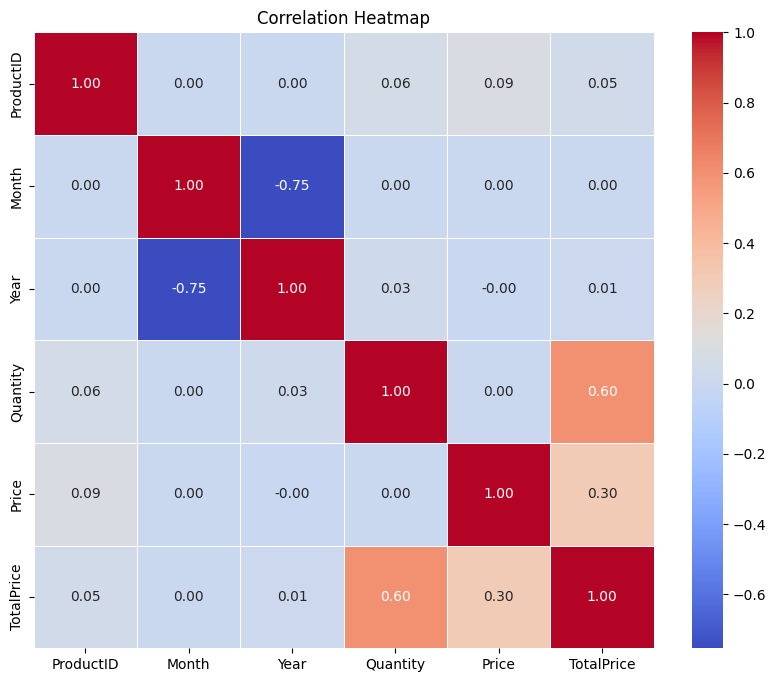

In [47]:
columns_of_interest = ['ProductID','Month', 'Year', 'Quantity', 'Price', 'TotalPrice']

subset_df = sales_data[columns_of_interest]
correlation_matrix = subset_df.corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()

# Starting Model Building

In [48]:
# Grouping data to get monthly sales
data = sales_data.groupby(['Year','Month','ProductID','Price'])
monthly_grouped_df = data['TotalPrice'].sum().reset_index()
monthly_grouped_df

,Year,Month,ProductID,Price,TotalPrice
0,2022,4,1,1749.0,118932.0
1,2022,4,2,1129.0,74514.0
2,2022,4,3,1129.0,94836.0
3,2022,4,4,1129.0,68869.0
4,2022,4,5,1129.0,62095.0
...,...,...,...,...,...
7579,2023,3,628,489.0,107091.0
7580,2023,3,629,499.0,89820.0
7581,2023,3,630,449.0,74534.0
7582,2023,3,631,542.0,62872.0


In [49]:
# making dataframe for features and targate variable
x = monthly_grouped_df[['Year','Month','ProductID','Price']]
y = monthly_grouped_df['TotalPrice']

In [50]:
x

,Year,Month,ProductID,Price
0,2022,4,1,1749.0
1,2022,4,2,1129.0
2,2022,4,3,1129.0
3,2022,4,4,1129.0
4,2022,4,5,1129.0
...,...,...,...,...
7579,2023,3,628,489.0
7580,2023,3,629,499.0
7581,2023,3,630,449.0
7582,2023,3,631,542.0


In [51]:
# Splitting data in to test and train
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=35)

In [52]:
# Using XG Boost model for prediction
model =  xgb.XGBRegressor(
    max_depth=4, 
    min_child_weight=1, 
    gamma=0, 
    subsample=0.8, 
    colsample_bytree=0.6, 
    reg_alpha=0.1, 
    reg_lambda=0.1
)
model.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Model Accuracy

In [53]:
# cheking r2 score for our models accuracy
y_pred = model.predict(x_test)
r2 = r2_score(y_test, y_pred)
print(f"R2 score on test data: {r2:.2f}")

R2 score on test data: 0.93


Visualization

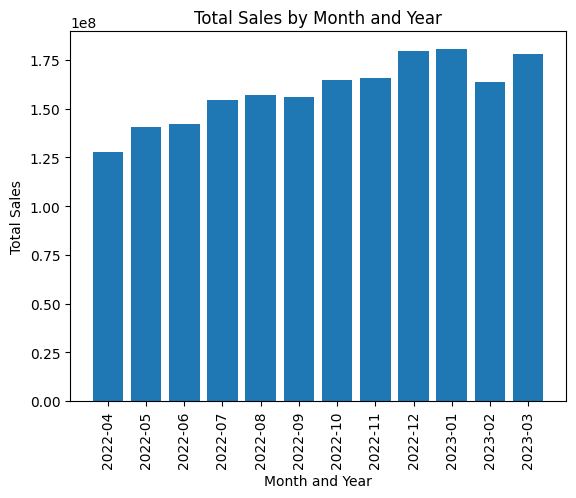

In [54]:
sales_data['MonthYear'] = pd.to_datetime(sales_data['Date']).dt.to_period('M')
monthly_sales = sales_data.groupby('MonthYear')['TotalPrice'].sum()

plt.bar(monthly_sales.index.astype(str), monthly_sales.values)
plt.title('Total Sales by Month and Year')
plt.xlabel('Month and Year')
plt.ylabel('Total Sales')
plt.xticks(rotation=90)
plt.show()

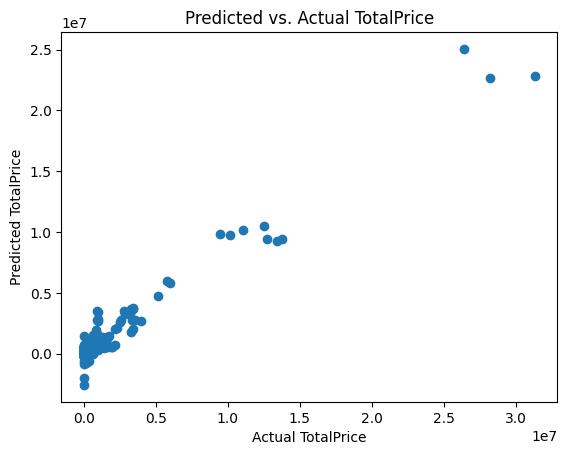

In [55]:
# Visualize predicted vs. actual values
plt.scatter(y_test, y_pred)
plt.xlabel('Actual TotalPrice')
plt.ylabel('Predicted TotalPrice')
plt.title('Predicted vs. Actual TotalPrice')
plt.show()

# Predicting the sales for next 6 month

In [64]:
# Reading the test data
future_data = pd.read_csv("Test_data_next_6months.csv")
future_data

,Year,Month,ProductID,Price
0,2023,4,1,1749
1,2023,4,2,1129
2,2023,4,3,1129
3,2023,4,4,1129
4,2023,4,5,1129
...,...,...,...,...
3787,2023,9,628,489
3788,2023,9,629,499
3789,2023,9,630,449
3790,2023,9,631,542


In [65]:
# Predicting sales using the model
pred = model.predict(future_data)
pred_data = pd.DataFrame(pred)
pred_data

,0
0,136905.359375
1,141601.593750
2,141601.593750
3,130626.304688
4,130626.304688
...,...
3787,91288.789062
3788,91288.789062
3789,91288.789062
3790,79713.343750


In [66]:
# Concatnating the predicted column to the test dataset
future_6month_pred = pd.concat([future_data,pred_data],axis=1)
future_6month_pred.rename(columns={0:"TotalPrice"},inplace=True)
future_6month_pred

,Year,Month,ProductID,Price,TotalPrice
0,2023,4,1,1749,136905.359375
1,2023,4,2,1129,141601.593750
2,2023,4,3,1129,141601.593750
3,2023,4,4,1129,130626.304688
4,2023,4,5,1129,130626.304688
...,...,...,...,...,...
3787,2023,9,628,489,91288.789062
3788,2023,9,629,499,91288.789062
3789,2023,9,630,449,91288.789062
3790,2023,9,631,542,79713.343750


In [67]:
# Grouping the data to get overall monthly sales from actual dataset
grouped = monthly_grouped_df.groupby(["Year","Month"])
month_actual_sales = grouped["TotalPrice"].sum().reset_index()
month_actual_sales_df = pd.DataFrame(month_actual_sales)
month_actual_sales_df["Date"] = month_actual_sales_df["Year"].astype(str) +"/"+ month_actual_sales_df["Month"].astype(str)
month_actual_sales_df

,Year,Month,TotalPrice,Date
0,2022,4,127641790.0,2022/4
1,2022,5,140698600.0,2022/5
2,2022,6,142425865.0,2022/6
3,2022,7,154625245.0,2022/7
4,2022,8,157283307.0,2022/8
5,2022,9,156163890.0,2022/9
6,2022,10,164647878.0,2022/10
7,2022,11,165741695.0,2022/11
8,2022,12,179724466.0,2022/12
9,2023,1,180622596.0,2023/1


In [68]:
# Grouping the data to get overall monthly sales from preedicted dataset
group = future_6month_pred.groupby(["Year","Month"])
month6_pred = group["TotalPrice"].sum().reset_index()
month6_pred_sales_df = pd.DataFrame(month6_pred)
month6_pred_sales_df["Date"] = month6_pred_sales_df["Year"].astype(str) +"/"+ month6_pred_sales_df["Month"].astype(str)
month6_pred_sales_df

,Year,Month,TotalPrice,Date
0,2023,4,167000800.0,2023/4
1,2023,5,173781520.0,2023/5
2,2023,6,174999984.0,2023/6
3,2023,7,175746496.0,2023/7
4,2023,8,176123296.0,2023/8
5,2023,9,176463056.0,2023/9


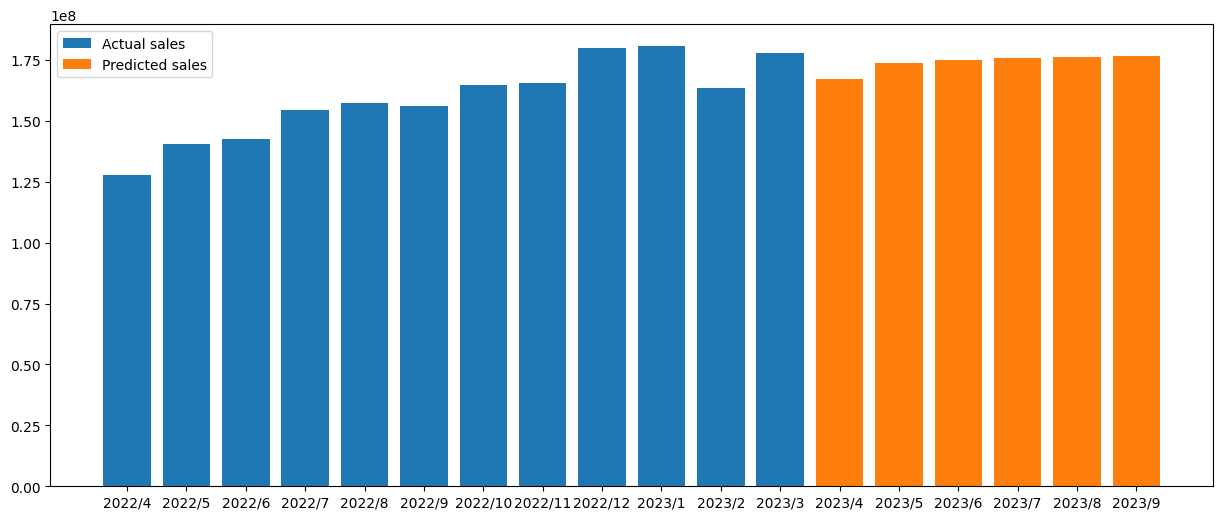

In [69]:
# plotting overall sales with prediction
fig, ax = plt.subplots(figsize=(15, 6))
ax.bar(month_actual_sales_df.Date,month_actual_sales_df.TotalPrice,label='Actual sales')
ax.bar(month6_pred_sales_df.Date,month6_pred_sales_df.TotalPrice,label='Predicted sales')

plt.legend()
plt.show()